#### Analysis of word embeddings
This script helps you to analyze whether fine-tuning with scrambled datasets lead the model to reassociate the embedding layer.

In [330]:
from analysis_util import *
cache_dir = "../tmp/"

In [ ]:
dist_to_plot = {}

In [321]:
# task setups
task_name = "snli"
# random seeds
# WARNING: this may change your results as well. Try it a few different seeds.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [322]:
if task_name == "conll2003":
    dataset = load_dataset("conll2003", cache_dir=cache_dir)
    train_df = dataset["train"]
    eval_df = dataset["validation"]
    test_df = dataset["test"]
elif task_name == "en_ewt":
    dataset = load_dataset("universal_dependencies", "en_ewt", cache_dir=cache_dir)
    train_df = dataset["train"]
    eval_df = dataset["validation"]
    test_df = dataset["test"]
else:
    # handle token data differently
    train_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                        f"train.tsv"), 
                           delimiter="\t")
    eval_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                       f"dev.tsv"), 
                          delimiter="\t")
    test_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                       f"test.tsv"), 
                          delimiter="\t")

    train_df = Dataset.from_pandas(train_df)
    eval_df = Dataset.from_pandas(eval_df)
    test_df = Dataset.from_pandas(test_df)

In [323]:
print("**** Dataset Statistics ****")
print(f"training example = {len(train_df)}")
print(f"validation example = {len(eval_df)}")
print(f"testing example = {len(test_df)}")
print("****************************")

**** Dataset Statistics ****
training example = 550152
validation example = 10000
testing example = 10000
****************************


In [324]:
# we need to first get the swapping dictionary.
# this tokenizer helps you to get piece length for each token
modified_tokenizer = ModifiedBertTokenizer(
    vocab_file="../data-files/bert_vocab.txt")
modified_basic_tokenizer = ModifiedBasicTokenizer()

def token_stats_mapping(task, example):
    
    # for tasks that have single sentence
    if task == "sst3" or task == "wiki-text" or task == "cola":
        original_sentence = example[TASK_CONFIG[task][0]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            if len(original_sentence.strip()) != 0:
                tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
                for token, pieces in token_dict.items():
                    if token in token_frequency_map.keys():
                        token_frequency_map[token] = token_frequency_map[token] + 1
                    else:
                        token_frequency_map[token] = 1
                    _len = len(pieces)
                    if _len in token_by_length.keys():
                        if token not in token_by_length[_len]:
                            token_by_length[_len].append(token)
                    else:
                        token_by_length[_len] = [token]
    # for tasks that have two sentences
    elif task == "mrpc" or task == "mnli" or task == "snli" or task == "qnli":
        original_sentence = example[TASK_CONFIG[task][0]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
            for token, pieces in token_dict.items():
                if token in token_frequency_map.keys():
                    token_frequency_map[token] = token_frequency_map[token] + 1
                else:
                    token_frequency_map[token] = 1
                _len = len(pieces)
                if _len in token_by_length.keys():
                    if token not in token_by_length[_len]:
                        token_by_length[_len].append(token)
                else:
                    token_by_length[_len] = [token]
                
        original_sentence = example[TASK_CONFIG[task][1]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
            for token, pieces in token_dict.items():
                if token in token_frequency_map.keys():
                    token_frequency_map[token] = token_frequency_map[token] + 1
                else:
                    token_frequency_map[token] = 1
                _len = len(pieces)
                if _len in token_by_length.keys():
                    if token not in token_by_length[_len]:
                        token_by_length[_len].append(token)
                else:
                    token_by_length[_len] = [token]
    elif task == "conll2003" or task == "en_ewt":
        # we have the words already!
        tokens = example[TASK_CONFIG[task][0]]
        for token in tokens:
            if token in token_frequency_map.keys():
                token_frequency_map[token] = token_frequency_map[token] + 1
            else:
                token_frequency_map[token] = 1
            _len = 1 # all is one!
            if _len in token_by_length.keys():
                if token not in token_by_length[_len]:
                    token_by_length[_len].append(token)
            else:
                token_by_length[_len] = [token]
    else:
        print(f"task={task} not supported yet!")
    return example

token_by_length = {} # overwrite this everytime for a new dataset
token_frequency_map = {} # overwrite this everytime for a new dataset
train_df = train_df.map(partial(token_stats_mapping, task_name))
eval_df = eval_df.map(partial(token_stats_mapping, task_name))
test_df = test_df.map(partial(token_stats_mapping, task_name))
task_token_by_length = OrderedDict(token_by_length)
task_token_frequency_map = sorted(token_frequency_map.items(), key=operator.itemgetter(1), reverse=True)
task_token_frequency_map = OrderedDict(task_token_frequency_map)
# mismatch script
vocab_match_frequency_iv = \
    generate_vocab_match_frequency_iv(task_token_by_length, 
                                      task_token_frequency_map)

#### Proximity Tests

With pretrained BERT embeddings, we often can see words (tokens) with similiar meanings are clustered together. If we now scramble words, and if the finetuned model learns how our scrambling mapping through relearning the embeddings, the proximity should be similiar. Words that are clustered together before the finetuning should also stay closer after finetuning.

In [331]:
# Loading models and setups
model_name_or_path = f"../{FILENAME_CONFIG[task_name]}-corrupted-matched-result/{SUBDIR_CONFIG[task_name]}-sample/"
cache_dir = "../tmp/"
finetuned_config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=NUM_LABELS[task_name],
    finetuning_task=task_name,
    cache_dir=cache_dir
)
fintuned_model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path,
    from_tf=False,
    config=finetuned_config,
    cache_dir=cache_dir
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    use_fast=False,
    cache_dir=cache_dir
)
pretrained_config = AutoConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=NUM_LABELS[task_name],
    finetuning_task=task_name,
    cache_dir=cache_dir
)
pretrained_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    from_tf=False,
    config=pretrained_config,
    cache_dir=cache_dir
)
pretrained_embeddings = pretrained_model.bert.embeddings.word_embeddings.weight.data
fintuned_embeddings = fintuned_model.bert.embeddings.word_embeddings.weight.data
model_vocab = tokenizer.vocab
# process the bert vocab a little bit
filtered_bert_emb = []
filtered_fintuned_emb = []
bert_vocab = OrderedDict({})
bert_vocab_reversed = OrderedDict({})
new_bert_idx = 0
for bert_token, bert_idx in model_vocab.items():
    if bert_idx < 1997 or not isEnglish(bert_token):
        continue
    # skip unused
    import re
    if "[unused" not in bert_token and not hasNumbers(bert_token):
        if bert_token in vocab_match_frequency_iv:
            bert_vocab[bert_token] = new_bert_idx
            bert_vocab_reversed[new_bert_idx] = bert_token
            filtered_bert_emb.append(pretrained_embeddings[bert_idx])
            filtered_fintuned_emb.append(fintuned_embeddings[bert_idx])
            new_bert_idx += 1
filtered_bert_emb = torch.stack(filtered_bert_emb, dim=0)
filtered_fintuned_emb = torch.stack(filtered_fintuned_emb, dim=0)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [332]:
bert_proximity = in_vocab_proximity(filtered_bert_emb, bert_vocab_reversed)

100%|██████████| 14037/14037 [07:46<00:00, 30.07it/s]


In [333]:
finetuned_proximity = in_vocab_proximity(filtered_fintuned_emb, bert_vocab_reversed, translate_dict=vocab_match_frequency_iv)

100%|██████████| 14037/14037 [07:49<00:00, 29.92it/s]


In [334]:
initial_finetuned_proximity = in_vocab_proximity(filtered_bert_emb, bert_vocab_reversed, translate_dict=vocab_match_frequency_iv)

100%|██████████| 14037/14037 [08:04<00:00, 28.99it/s]  


In [335]:
finetuned_proximity_dist = proximity_correlation(bert_proximity, finetuned_proximity)

100%|██████████| 14037/14037 [04:18<00:00, 54.20it/s]


In [336]:
initial_finetuned_proximity_dist = proximity_correlation(bert_proximity, initial_finetuned_proximity)

100%|██████████| 14037/14037 [04:29<00:00, 52.17it/s]  


In [337]:
dist_to_plot[task_name] = (finetuned_proximity_dist, initial_finetuned_proximity_dist)

Finally, let us plot these distributions

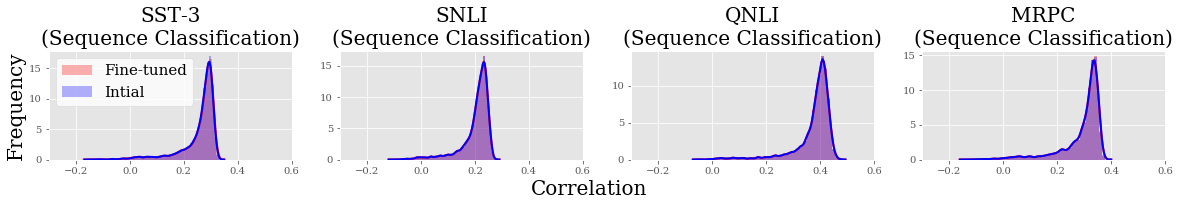

In [353]:
import seaborn as sns
plt.style.use("ggplot")
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 10}
plt.rc('font', **font)

fig, axs = plt.subplots(1, 4, figsize=(20, 2))
kwargs = dict(
    hist_kws={'alpha':.3}, kde_kws={'linewidth':2}
)
sns.distplot(ax=axs[0], a=dist_to_plot["sst3"][0], color="red", label="Fine-tuned", **kwargs)
sns.distplot(ax=axs[0], a=dist_to_plot["sst3"][1], color="blue", label="Intial", **kwargs)
axs[0].set_title('SST-3\n(Sequence Classification)', fontsize=20)
axs[0].legend(facecolor="white", loc="upper left", fontsize=15)
# TODO: We need to replace this!
sns.distplot(ax=axs[1], a=dist_to_plot["snli"][0], color="red", **kwargs)
sns.distplot(ax=axs[1], a=dist_to_plot["snli"][1], color="blue", **kwargs)
axs[1].set_title('SNLI\n(Sequence Classification)', fontsize=20)
sns.distplot(ax=axs[2], a=dist_to_plot["qnli"][0], color="red", **kwargs)
sns.distplot(ax=axs[2], a=dist_to_plot["qnli"][1], color="blue", **kwargs)
axs[2].set_title('QNLI\n(Sequence Classification)', fontsize=20)
sns.distplot(ax=axs[3], a=dist_to_plot["mrpc"][0], color="red", **kwargs)
sns.distplot(ax=axs[3], a=dist_to_plot["mrpc"][1], color="blue", **kwargs)
axs[3].set_title('MRPC\n(Sequence Classification)', fontsize=20)
axs[0].set_xlim(-0.3, 0.6)
axs[1].set_xlim(-0.3, 0.6)
axs[2].set_xlim(-0.3, 0.6)
axs[3].set_xlim(-0.3, 0.6)
fig.text(0.5, -0.12, 'Correlation', ha='center', size=20)
fig.text(0.096, 0.5, 'Frequency', va='center', rotation='vertical', size=20)
# plt.show()
plt.savefig("../data-files/embedding-transform-result.png",dpi=1000,bbox_inches='tight')